In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested
from phe import *
from phe import map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

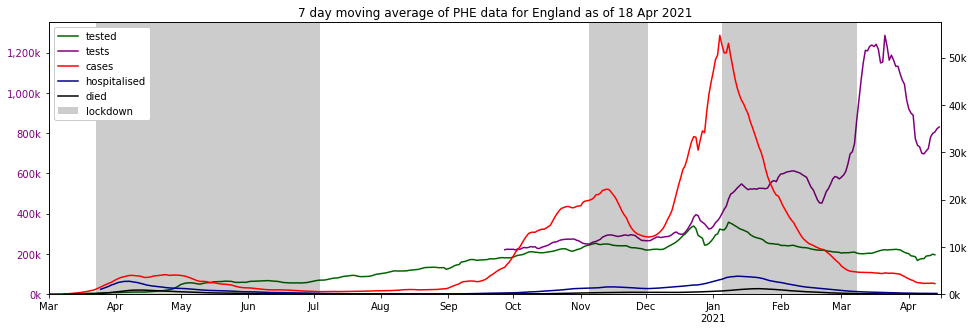

In [2]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

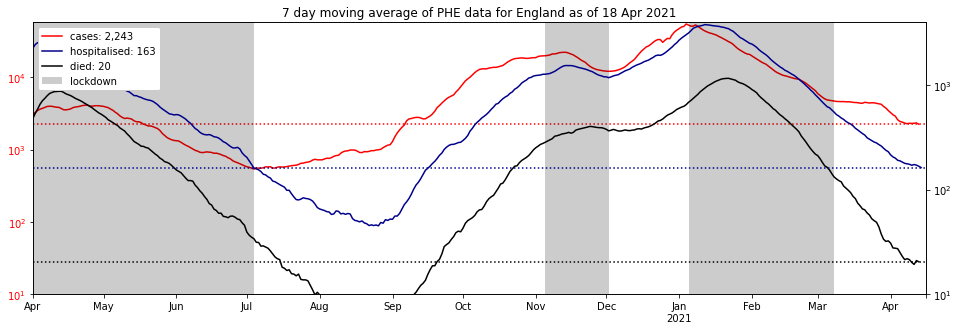

In [3]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

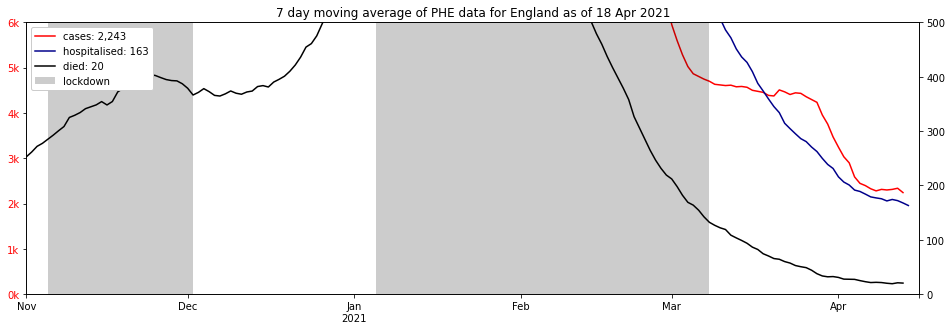

In [4]:
plot_summary(earliest_date='2020-11-01', show_latest=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=6_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=500)

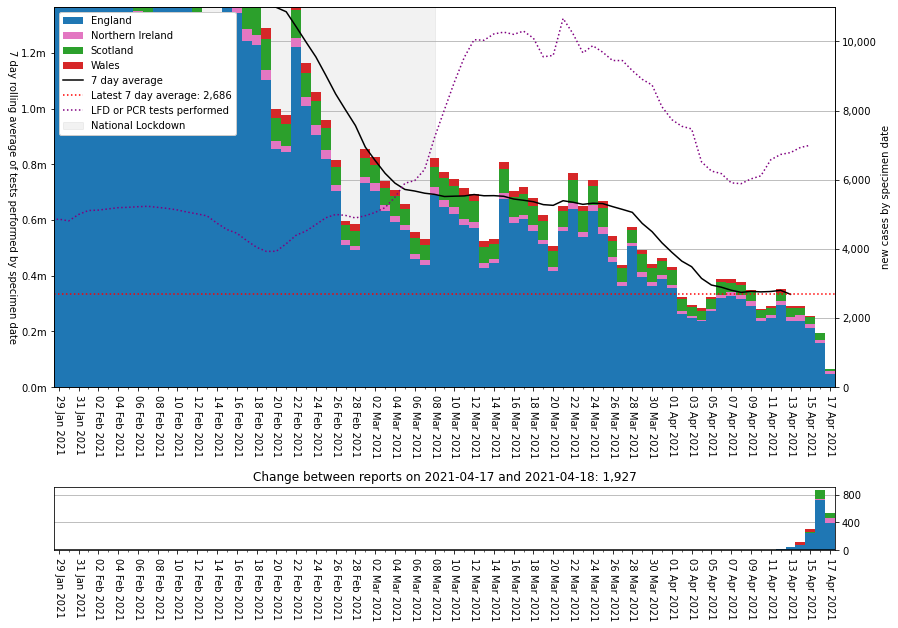

In [5]:
plot_areas(for_date, 'cases_nations', ylim=11_000, earliest='2021-01-29')

In [6]:
vaccination_changes()

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,8322627.0,27559381.0,19236754.0,56286961,14.786066,34.176217,51.037717
1,Northern Ireland,N92000002,268341.0,860313.0,591972.0,1893667,14.170443,31.260618,54.568940
2,Scotland,S92000003,738420.0,2744231.0,2005811.0,5463300,13.516007,36.714275,49.769718
3,Wales,W92000004,601458.0,1685298.0,1083840.0,3152879,19.076469,34.376200,46.547330


'partial: 32,849,223 (49.2%), full: 9,930,846'

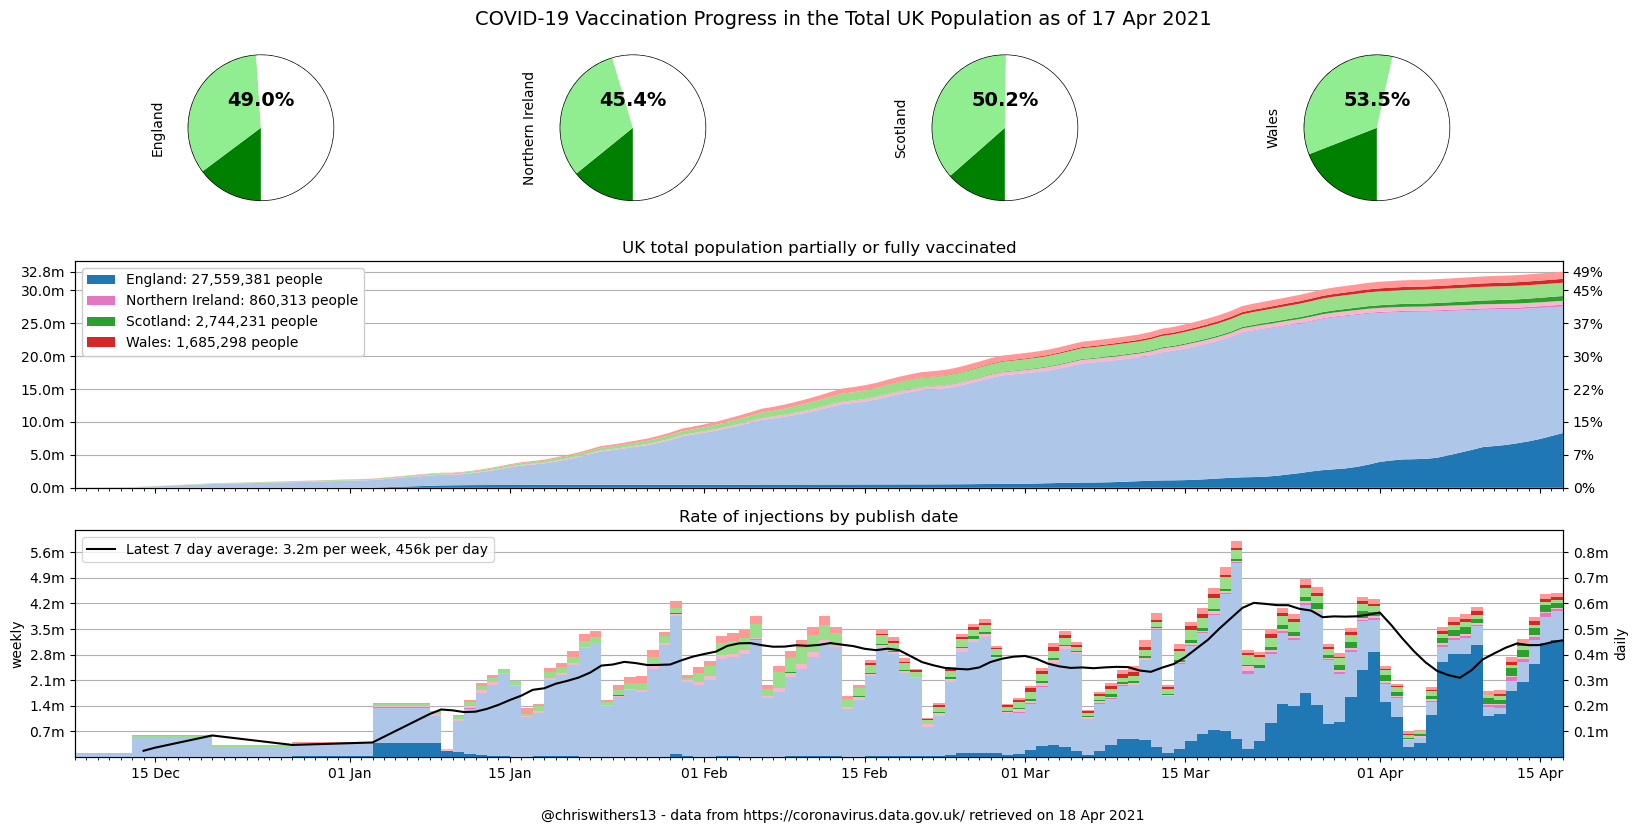

In [7]:
results = vaccination_dashboard(show_partial=True)
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

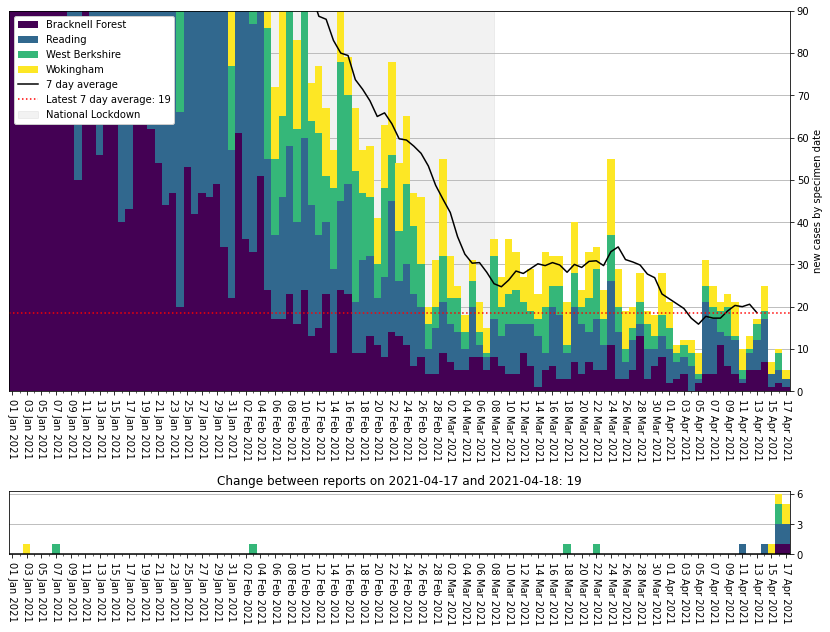

In [8]:
plot_areas(for_date, areas=my_areas, earliest='2021-01-01', ylim=90)

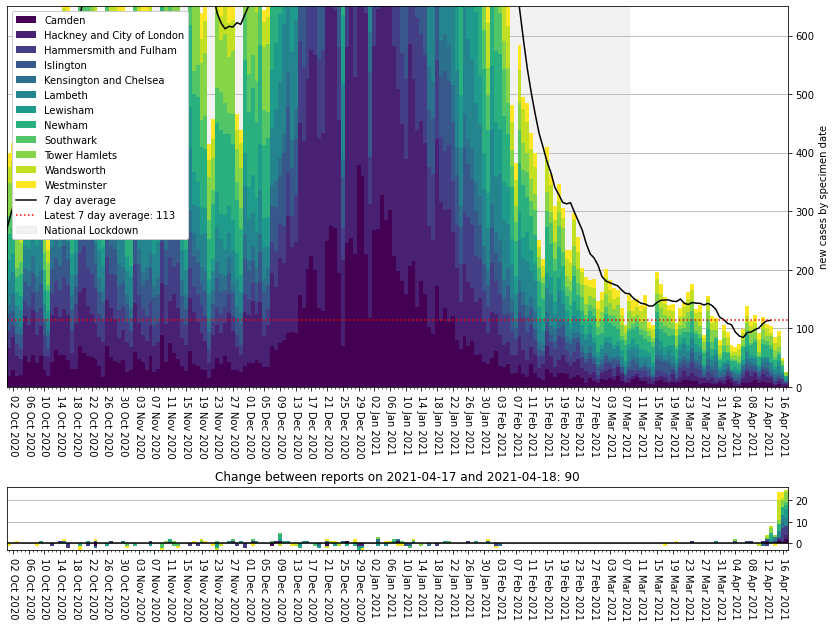

In [9]:
plot_areas(for_date, areas=london_areas, ylim=650)

In [10]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [11]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
N09000005,Derry City and Strabane,105.761350,160.0,2021-04-17
E06000032,Luton,65.711657,140.0,2021-04-17
E08000017,Doncaster,62.522043,195.0,2021-04-17
N09000009,Mid Ulster,59.921362,89.0,2021-04-17
N09000010,"Newry, Mourne and Down",56.790614,103.0,2021-04-17
E06000016,Leicester,56.461448,200.0,2021-04-17
S12000005,Clackmannanshire,56.266977,29.0,2021-04-17
E06000010,"Kingston upon Hull, City of",55.047002,143.0,2021-04-17
E08000032,Bradford,52.799680,285.0,2021-04-17


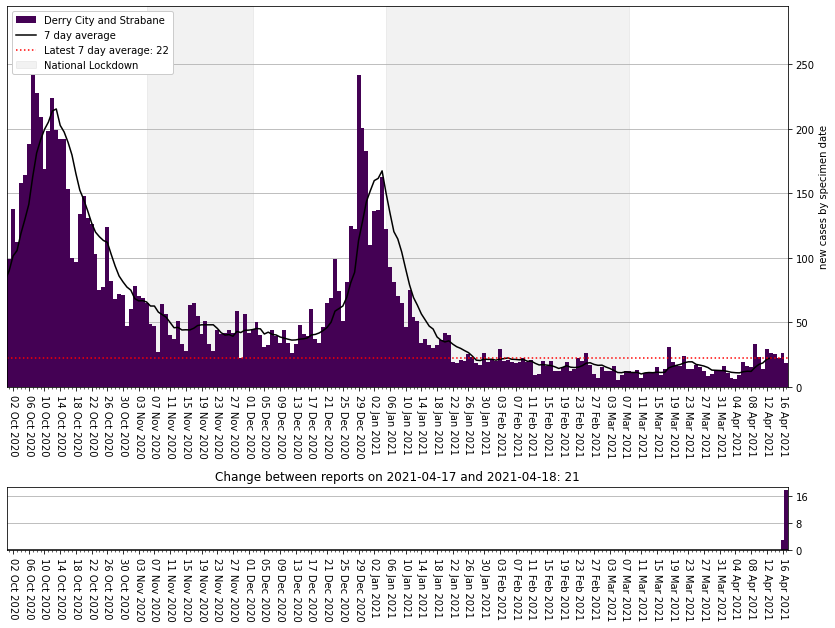

In [12]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [13]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
S12000049,Glasgow City,51.491029,326.0,2021-04-17
E08000035,Leeds,37.067904,294.0,2021-04-17
E08000032,Bradford,52.799680,285.0,2021-04-17
E08000019,Sheffield,40.864969,239.0,2021-04-17
E08000025,Birmingham,19.092393,218.0,2021-04-17
E08000034,Kirklees,48.887302,215.0,2021-04-17
E08000003,Manchester,37.441802,207.0,2021-04-17
E06000016,Leicester,56.461448,200.0,2021-04-17
E08000017,Doncaster,62.522043,195.0,2021-04-17


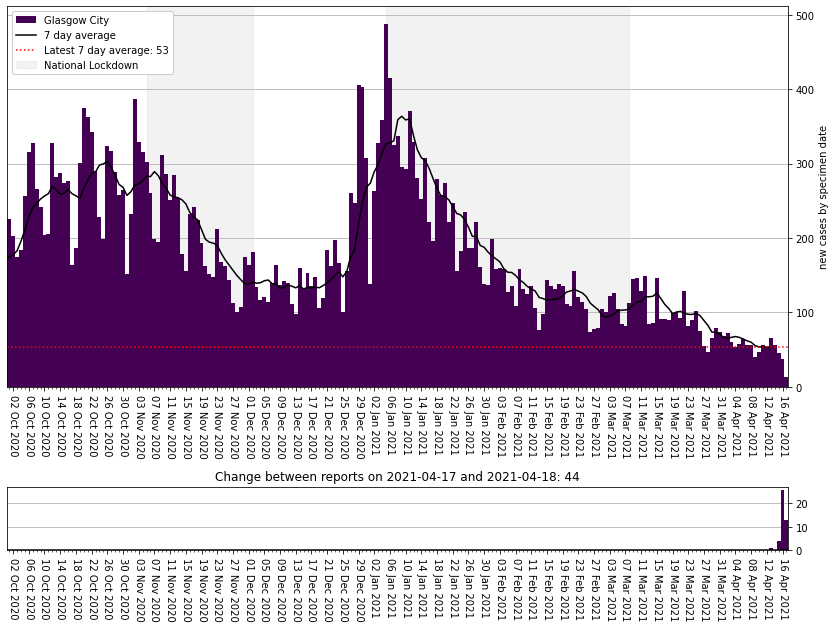

In [14]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [22]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 0.7
phe_max = 0.13

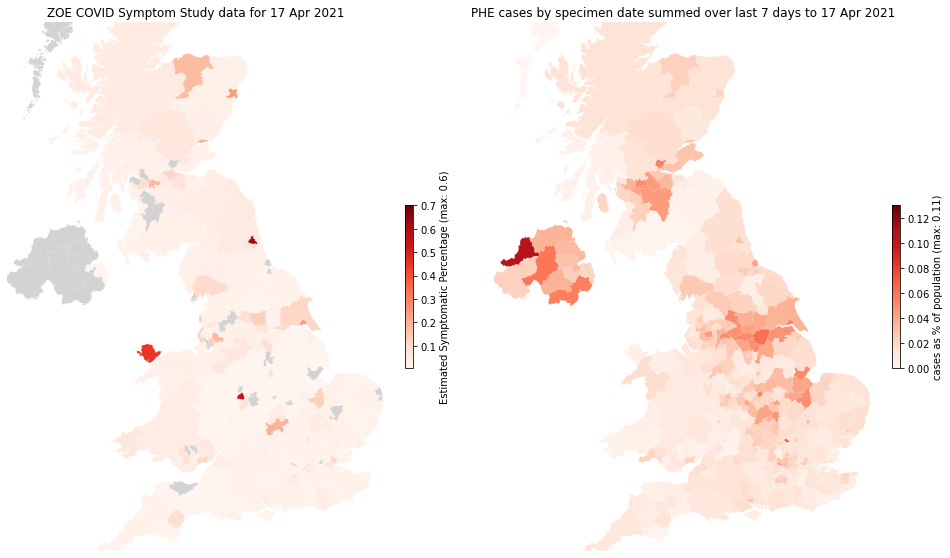

In [23]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [24]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...